
### **Gezgin Satıcı Problemi (Traveling Salesman Problem - TSP) Proje Raporu**

Bu rapor, Gezgin Satıcı Problemi'nin (TSP) çözümü için geliştirilen Genetik Algoritma (GA) tabanlı bir yaklaşımı detaylandırmaktadır. Problem, belirli bir şehirler kümesi için her şehre tam olarak bir kez uğrayıp başlangıç noktasına geri dönülen en kısa rotanın bulunmasıdır. Amaç, toplam seyahat mesafesini minimize etmektir. Geliştirilen program, TSPLIB formatındaki problem örneklerini okuyabilmekte, farklı GA parametrelerini sistematik olarak test ederek en iyi çözümü bulmakta ve sonuçları görselleştirmektedir.

---

### **a. Problem Formulation (Problemin Formüle Edilmesi)**

### **Gezgin Satıcı Problemi'nin (TSP) Matematiksel Formülasyonu**

Gezgin Satıcı Problemi, genellikle bir Tamsayılı Doğrusal Programlama (Integer Linear Programming - ILP) problemi olarak formüle edilir. Amaç, tüm şehirleri ziyaret eden ve toplam maliyeti (mesafeyi) minimize eden bir tur bulmaktır.

#### **1. Parametreler ve Kümeler**

*   **n**: Toplam şehir sayısı.
*   **V**: Şehirlerin (düğümlerin) kümesi, $V = \{1, 2, ..., n\}$.
*   **$c_{ij}$**: Şehir `i`'den şehir `j`'ye gitmenin maliyeti (mesafesi).

#### **2. Karar Değişkenleri**

Karar değişkenimiz, bir şehirden diğerine giden yolun turda kullanılıp kullanılmadığını belirten ikili (binary) bir değişkendir.

$$
x_{ij} = \begin{cases} 1, & \text{eğer rota } i \text{ şehrinden } j \text{ şehrine direkt gidiyorsa} \\ 0, & \text{aksi halde} \end{cases}
$$

Bu değişken $i, j \in V$ ve $i \neq j$ için tanımlıdır. Bir şehirden kendisine giden bir yol olamaz ($x_{ii} = 0$).

#### **3. Amaç Fonksiyonu**

Amaç, turdaki tüm yolların toplam maliyetini minimize etmektir.

$$
\text{Minimize} \quad Z = \sum_{i \in V} \sum_{j \in V, j \neq i} c_{ij} x_{ij}
$$

Bu formül, tüm olası şehir çiftleri $(i, j)$ için, eğer o yol turda kullanılıyorsa ($x_{ij}=1$) mesafeyi ($c_{ij}$) toplama ekler.

#### **4. Kısıtlar**

Modelin geçerli bir tur oluşturmasını sağlamak için aşağıdaki kısıtlar gereklidir:

**a) Her Şehre Tam Olarak Bir Kez Girilmelidir:**
Her şehir için, o şehre gelen yolların sayısı tam olarak 1 olmalıdır.

$$
\sum_{i \in V, i \neq j} x_{ij} = 1 \quad \forall j \in V
$$

**b) Her Şehirden Tam Olarak Bir Kez Çıkılmalıdır:**
Benzer şekilde, her şehirden ayrılan yolların sayısı da tam olarak 1 olmalıdır.

$$
\sum_{j \in V, j \neq i} x_{ij} = 1 \quad \forall i \in V
$$

**c) Alt Tur Eliminasyon Kısıtları (Subtour Elimination Constraints):**
Yukarıdaki iki kısıt, tek bir tam tur yerine birden fazla bağımsız döngü (alt tur) oluşmasına izin verebilir (örneğin, 5 şehirli bir problemde 1->2->1 ve 3->4->5->3 gibi). Bunu önlemek için ek kısıtlar gerekir. En yaygın yöntemlerden biri, şehirlerin herhangi bir alt kümesinde kapalı bir döngü oluşmasını engellemektir.

$S$, şehirler kümesi $V$'nin boş olmayan ve $V$'den farklı herhangi bir alt kümesi olsun ($S \subset V, S \neq \emptyset, S \neq V$). Bu alt küme içindeki yolların sayısı, o kümedeki şehir sayısından bir eksik veya daha az olmalıdır. Bu, $S$ içindeki şehirlerin kendi aralarında bir tur oluşturmasını engeller.

$$
\sum_{i \in S} \sum_{j \in S, j \neq i} x_{ij} \le |S| - 1 \quad \forall S \subset V, 2 \le |S| \le n-1
$$

**Not:** Bu kısıtların sayısı, şehir sayısıyla birlikte üssel olarak ($2^n$) arttığı için, TSP'yi NP-zor (NP-hard) bir problem yapan temel neden budur. Bu yüzden büyük problemler için Genetik Algoritmalar gibi sezgisel (heuristic) yöntemler tercih edilir.

**d) Değişken Türü Kısıtı:**
Karar değişkenleri ikili (binary) olmalıdır.

$$
x_{ij} \in \{0, 1\} \quad \forall i, j \in V, i \neq j
$$

#### **Chromosome Representation (Kromozom Temsili)**
Problemimiz için **permutasyon tabanlı bir kromozom temsili** seçilmiştir. Her bir kromozom (birey), gezginin şehirleri ziyaret edeceği sırayı temsil eden bir tamsayı listesidir. Örneğin, 5 şehirlik bir problem için `[2, 0, 4, 1, 3]` şeklindeki bir kromozom, turun 2. şehirden başlayıp sırasıyla 0, 4, 1 ve 3. şehirlere giderek tamamlandığını ifade eder. Bu temsil, her şehrin tam olarak bir kez ziyaret edilmesi kısıtını doğal olarak sağlar.

Kodda bu yapı, `create_individual(num_cities)` fonksiyonu ile gerçekleştirilir. Bu fonksiyon, `0`'dan `num_cities - 1`'e kadar olan şehir indekslerini içeren bir liste oluşturur ve bu listeyi `random.shuffle()` ile karıştırarak geçerli ve rastgele bir başlangıç turu (kromozom) meydana getirir.

#### **Objective Function (Amaç Fonksiyonu)**
Algoritmanın amacı toplam tur mesafesini minimize etmektir. Bu amaç, bir **uygunluk fonksiyonu (fitness function)** ile ölçülür. Bu projede uygunluk değeri, turun toplam mesafesidir ve daha düşük bir değer, daha iyi bir çözümü ifade eder.

Bu fonksiyon, kodda `total_distance(tour, cities_coords)` olarak implemente edilmiştir. Bu fonksiyon, bir kromozom (tur) ve şehir koordinatlarını girdi olarak alır. Kromozomdaki şehirleri sırayla dolaşarak, ardışık şehirler arasındaki Öklid mesafesini (`calculate_distance` fonksiyonu ile) hesaplar ve bu mesafeleri toplar. Turun döngüsel yapısını sağlamak için son şehirden ilk şehre olan mesafe de toplama dahil edilir.

#### **Problem Instance Structure (Problem Örneğinin Yapısı ve Kısıtları)**
Algoritma, standart TSP problem örnekleriyle çalışacak şekilde tasarlanmıştır. `read_tsp_file(file_path)` fonksiyonu, TSPLIB formatına benzer yapıdaki `.txt` dosyalarını okumak üzere yazılmıştır. Bu dosyalar, şehir sayısını ve her bir şehrin 2D (x, y) koordinatlarını içerir. Program, bu koordinatları bir sözlük yapısında (`cities_coords`) saklayarak mesafe hesaplamalarında kullanır. Temel kısıt, her şehrin rotada yalnızca bir kez yer almasıdır ve bu, seçilen permütasyon tabanlı kromozom temsili ile garanti altına alınmıştır.

---

### **b. Genetic Algorithm Implementation (Genetik Algoritma Uygulaması)**

Geliştirilen GA, aşağıdaki bileşenleri içeren tam bir yapıya sahiptir:

*   **Population Initialization (Popülasyonun Başlatılması):** `create_initial_population(num_cities, population_size)` fonksiyonu, belirtilen popülasyon büyüklüğü kadar rastgele ve geçerli birey (tur) oluşturarak başlangıç popülasyonunu meydana getirir.

*   **Selection Mechanism (Seçilim Mekanizması):** **Turnuva Seçilimi (Tournament Selection)** yöntemi kullanılmıştır. `tournament_selection(population, fitness_scores, k)` fonksiyonu, popülasyondan rastgele `k` adet birey seçer ve bunlar arasından en iyi uygunluk değerine (en düşük mesafeye) sahip olan bireyi ebeveyn olarak döndürür. Bu yöntem, daha iyi bireylerin seçilme şansını artırırken, genetik çeşitliliğin korunmasına da yardımcı olur.

*   **Crossover Operator (Çaprazlama Operatörü):** Permütasyon tabanlı kromozomlar için uygun olan **Sıralı Çaprazlama (Order Crossover - OX1)** operatörü implemente edilmiştir. `order_crossover_ox1(parent1, parent2)` fonksiyonu, birinci ebeveynden rastgele bir alt dizi alır ve bunu doğrudan çocuğa kopyalar. Çocuğun kalan genleri ise ikinci ebeveynden, mevcut genlerle çakışmayacak şekilde sırayla alınarak doldurulur. Bu operatör, ebeveynlerin genetik bilgisini korurken geçerli yeni turlar (çocuklar) üretir.

*   **Mutation Operator (Mutasyon Operatörü):** **Tersine Çevirme Mutasyonu (Inversion Mutation)** operatörü kullanılmıştır. `inversion_mutation(individual, mutation_rate)` fonksiyonu, belirli bir mutasyon olasılığına bağlı olarak çalışır. Bir bireydeki genlerin rastgele seçilen bir alt dizisini (örneğin, 3. ve 7. şehirler arasındaki rota parçası) tersine çevirir. Bu yöntem, kromozomun geçerliliğini (permutasyon yapısını) bozmadan küçük ve rastgele değişiklikler yaparak yerel optimumlardan kaçmaya yardımcı olur.

*   **Replacement Strategy (Yerine Koyma Stratejisi):** **Elitizm ile Güçlendirilmiş Jenerasyonel Değişim** stratejisi benimsenmiştir. Her jenerasyonun sonunda, bir sonraki jenerasyon tamamen yeni oluşturulur. Ancak bu süreçte, mevcut jenerasyonun en iyi bireylerinden oluşan belirli bir oran (`elite_rate` ile belirlenen) doğrudan yeni jenerasyona aktarılır. Bu elitizm stratejisi, en iyi çözümlerin kaybolmasını önler. Geri kalan popülasyon ise seçilim, çaprazlama ve mutasyon adımları ile üretilen yeni çocuklardan oluşur. Eski popülasyon tamamen atılır ve yerine bu yeni oluşturulan popülasyon geçer.

---

### **c. Performance Analysis (Performans Analizi)**

*   **Convergence Analysis (Yakınsama Analizi):** Algoritmanın performansı, yakınsama analizi ile değerlendirilmektedir. `genetic_algorithm_tsp` fonksiyonu, her jenerasyondaki en iyi ve ortalama uygunluk değerlerini (`convergence_data` listesinde) kaydeder. `plot_results_combined_animated` fonksiyonu, bu verileri kullanarak "Jenerasyon vs. Toplam Mesafe" grafiği çizer. Bu grafik, algoritmanın ne kadar hızlı bir şekilde iyi çözümlere yakınsadığını ve zamanla gelişiminin durma noktasına gelip gelmediğini görsel olarak analiz etme imkanı tanır.

*   **Solution Quality (Çözüm Kalitesi):** Çözüm kalitesi, algoritmanın belirli bir problem örneği için bulduğu en kısa mesafe ile ölçülür. `parameter_tuning_experiment` fonksiyonu, çok sayıda farklı parametre kombinasyonunu deneyerek algoritmanın ulaşabileceği en iyi çözümü bulmaya çalışır. Bu en iyi sonuç, problemin bilinen optimal veya en iyi bilinen çözümleriyle (TSPLIB gibi kaynaklardan elde edilen) karşılaştırılarak algoritmanın genel başarısı değerlendirilebilir.

*   **Computational Efficiency (Hesaplama Verimliliği):** Algoritmanın verimliliği, çalışma süresi ile ölçülür. `genetic_algorithm_tsp` fonksiyonu, `time` modülünü kullanarak başlangıç ve bitiş zamanlarını kaydeder ve toplam hesaplama süresini döndürür. `parameter_tuning_experiment` fonksiyonu, her bir parametre denemesi için geçen süreyi raporlar. Bu, farklı parametrelerin (özellikle popülasyon büyüklüğü ve jenerasyon sayısı) algoritmanın çalışma hızını nasıl etkilediğini analiz etmemizi sağlar.

*   **Parameter Sensitivity Analysis (Parametre Duyarlılık Analizi):** Kod, parametre duyarlılık analizini sistematik bir şekilde yapmak üzere tasarlanmıştır. `parameter_tuning_experiment` fonksiyonu, `param_grid` içinde tanımlanan popülasyon büyüklüğü, çaprazlama oranı, mutasyon oranı, turnuva büyüklüğü (`tournament_k`) ve elitizm oranı gibi kritik parametrelerin farklı değerlerini dener. Her bir kombinasyon için GA'yı çalıştırır, sonuçları kaydeder ve tüm denemeler bittiğinde en iyi performansı gösteren parametre setini raporlar. Bu, hangi parametrelerin çözüm kalitesi üzerinde daha etkili olduğunu anlamak için kapsamlı bir analiz sunar.

---

### **d. Parameter Tuning/Optimization (Parametre Ayarlama/Optimizasyon)**

Parametre optimizasyonu, bu projenin temel özelliklerinden biridir. Manuel deneme-yanılma yerine, **Grid Search (Izgara Arama)** yöntemine dayalı sistematik bir yaklaşım benimsenmiştir. `parameter_tuning_experiment` fonksiyonu:
1.  Farklı parametreler (`population_size`, `crossover_rate` vb.) için bir dizi olası değer tanımlar.
2.  `itertools.product` kullanarak bu değerlerin tüm olası kombinasyonlarını oluşturur.
3.  Her bir kombinasyon için Genetik Algoritmayı çalıştırır.
4.  Elde edilen sonuçları (en kısa mesafe) karşılaştırarak en iyi sonucu veren parametre setini belirler ve raporlar.

Bu otomatikleştirilmiş süreç, algoritmanın belirli bir problem üzerinde en yüksek performansı göstereceği hiperparametre ayarlarını verimli bir şekilde bulmayı sağlar.

---

### **e. Advanced Selection or Elitism (Gelişmiş Seçilim veya Elitizm)**

*   **Selection:** Standart ancak oldukça etkili bir yöntem olan **Turnuva Seçilimi** kullanılmıştır. Bu mekanizma, `tournament_k` parametresi ile ayarlanabilir bir seçilim baskısı sunar. `k` değerinin artırılması, daha iyi bireylerin seçilme olasılığını yükseltirken, azaltılması genetik çeşitliliğin daha uzun süre korunmasına yardımcı olur.

*   **Elitism:** Basit ama çok güçlü bir **elitizm stratejisi** uygulanmıştır. `genetic_algorithm_tsp` fonksiyonu içinde, her jenerasyonun en iyi bireylerinin bir kısmı (`elite_rate` ile belirlenen oranda) doğrudan bir sonraki jenerasyona kopyalanır. Bu, algoritmanın evrim süreci boyunca bulduğu en iyi çözümü asla kaybetmemesini garanti altına alır ve yakınsama sürecini hızlandırır.

---

### **h. Visualization Tools (Görselleştirme Araçları)**

Algoritmanın sonuçlarını ve çalışma prensibini daha anlaşılır kılmak için kapsamlı görselleştirme araçları geliştirilmiştir. `plot_results_combined_animated` fonksiyonu, `matplotlib` ve `networkx` kütüphanelerini kullanarak iki parçalı bir sonuç ekranı oluşturur:

1.  **Yakınsama Grafiği (Sol Panel):** Bu grafik, jenerasyonlar ilerledikçe en iyi bireyin uygunluk değerindeki (toplam mesafe) düşüşü gösterir. Algoritmanın öğrenme eğrisini ve performans gelişimini görsel olarak sunar.
2.  **En İyi Tur Grafiği (Sağ Panel):** `networkx` kütüphanesi kullanılarak şehirler düğüm (node), en iyi bulunan rota ise kenar (edge) olarak çizilir. Bu görsel, bulunan en kısa yolun coğrafi temsilini sunar ve çözümün sezgisel olarak değerlendirilmesine olanak tanır. Grafiğin başlığında, bu turun toplam mesafesi de belirtilir.

Bu birleşik görselleştirme, hem algoritmanın içsel dinamiklerini (yakınsama) hem de nihai çıktısını (en iyi rota) tek bir bakışta analiz etme imkanı sunar.

#### 1. Gerekli Kütüphaneler
Projemizde matematiksel hesaplamalar, rastgele sayı üretimi, veri görselleştirme ve zaman ölçümü için çeşitli kütüphaneler kullanılmıştır.

math: Mesafeleri hesaplamak gibi temel matematiksel işlemler için.

random: Rastgele turlar (bireyler) oluşturmak, seçim ve mutasyon işlemleri için.

matplotlib.pyplot: Sonuçları ve yakınsama grafiğini görselleştirmek için.

networkx: Şehirleri ve rotaları bir graf yapısı olarak modellemek ve çizmek için.

time: Algoritmanın çalışma süresini ölçmek için.

itertools: Farklı parametre kombinasyonlarını denemek için.

In [ ]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import time
import itertools

# Yardımcı Fonksiyonlar ve Dosya Okuma

Genetik algoritmanın temel operasyonları için gerekli olan yardımcı fonksiyonlar bu bölümde tanımlanmıştır.

#### a. Şehirler Arası Mesafe Hesabı
İki şehir arasındaki Öklid mesafesini hesaplar. Eğer şehir 1'in koordinatları (x1,y1) ve şehir 2'nin koordinatları (x2,y2) ise, aralarındaki mesafe aşağıdaki formülle hesaplanır:


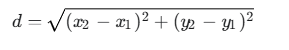

In [ ]:
def calculate_distance(city1_coords, city2_coords):
    # Pisagor teoremini kullanarak (x2-x1)^2 + (y2-y1)^2 formülünün karekökünü alarak mesafeyi döndürür.
    return math.sqrt((city1_coords[0] - city2_coords[0])**2 + \
                     (city1_coords[1] - city2_coords[1])**2)

#### b. Toplam Tur Mesafesi
Verilen bir rotanın (şehirlerin sıralı listesi) toplam mesafesini hesaplar. Bu, rotadaki her ardışık şehir çifti arasındaki mesafelerin toplanması ve son şehirden başlangıç şehrine geri dönüş mesafesinin eklenmesiyle yapılır. Bu fonksiyon, genetik algoritmada bir bireyin "uygunluk değerini" (fitness) belirler.

In [ ]:
# Verilen bir turun (şehirlerin sıralaması) toplam mesafesini hesaplayan fonksiyonu tanımlar.
def total_distance(tour, cities_coords):
    # Toplam mesafeyi saklamak için bir değişken başlatır.
    dist = 0
    # Turdaki toplam şehir sayısını alır.
    num_cities = len(tour)
    # Turdaki her bir şehir için döngü başlatır.
    for i in range(num_cities):
        # Mevcut şehri (tur listesindeki indeksi) alır.
        from_city_idx = tour[i]
        # Bir sonraki şehri alır. Modulo (%) operatörü, turun son şehrinden tekrar başlangıç şehrine dönülmesini sağlar.
        to_city_idx = tour[(i + 1) % num_cities]
        # Mevcut şehir ile bir sonraki şehir arasındaki mesafeyi hesaplar ve toplam mesafeye ekler.
        dist += calculate_distance(cities_coords[from_city_idx], \
                                   cities_coords[to_city_idx])
    # Hesaplanan toplam mesafeyi döndürür.
    return dist

#### c. TSP Dosyasını Okuma
Standart TSP problem örnekleriyle çalışabilmek için TSPLIB formatına benzer yapıdaki dosyalardan şehir koordinatlarını okuyan fonksiyondur. Dosyadan okunan şehir koordinatlarını bir sözlük yapısında saklar.

In [ ]:
# Belirtilen yoldaki bir TSP dosyasını okuyup şehir koordinatlarını bir sözlük olarak döndüren fonksiyon
def read_tsp_file(file_path):
    # Şehirlerin kimliklerini (ID) anahtar, koordinatlarını (x, y) değer olarak tutacak bir sözlük oluşturur.
    cities_coords = {}
    # Dosya okuma sırasında hata oluşma ihtimaline karşı bir try-except bloğu başlatır.
    try:
        # Dosyayı okuma modunda ('r') açar. 'with' ifadesi, dosyanın iş bittiğinde otomatik olarak kapanmasını sağlar.
        with open(file_path, 'r') as f:
            # Dosyanın ilk satırını okur ve baştaki/sondaki boşlukları temizler.
            num_cities_line = f.readline().strip()
            # İlk satırı boşluklara göre böler ve son elemanı (şehir sayısı) tamsayıya çevirir.
            num_cities = int(num_cities_line.split()[-1])
            # Şehir sayısı kadar döngüye girerek her bir şehir verisini okur.
            for i in range(num_cities):
                # Sıradaki satırı okur, boşlukları temizler ve kelimelere ayırır.
                line_content = f.readline().strip().split()
                # Satırdaki sondan ikinci ve birinci elemanları (x ve y koordinatları) ondalıklı sayıya çevirir ve sözlüğe ekler.
                cities_coords[i] = (float(line_content[-2]), float(line_content[-1]))
    # Dosya okuma sırasında bir hata (Exception) oluşursa bu blok çalışır.
    except Exception as e:
        # Oluşan hatayı ekrana yazdırır.
        print(f"Dosya okunurken bir hata oluştu: {e}")
        # Hata durumunda None (boş değer) döndürür.
        return None
    # Şehir koordinatlarını içeren sözlüğü döndürür.
    return cities_coords

# Genetik Algoritma Komponentleri

Genetik algoritma, evrimsel süreçleri taklit ederek optimizasyon problemlerine çözüm arar. Temel bileşenleri popülasyon, seçim, çaprazlama ve mutasyondur.

#### a. Birey ve Popülasyon Oluşturma
__Birey (Individual)__: GSP'de bir birey, şehirlerin ziyaret edilme sırasını temsil eden bir rotadır (örn: [0, 3, 1, 2]).

__Popülasyon (Population)__: Çok sayıda bireyden (rotadan) oluşan bir kümedir.
Algoritma, başlangıçta tamamen rastgele rotalardan oluşan bir başlangıç popülasyonu oluşturur.

In [ ]:
# Rastgele bir tur (birey) oluşturan fonksiyon
def create_individual(num_cities):
    # 0'dan şehir sayısına kadar olan sayıları içeren bir liste oluşturur (örn: [0, 1, 2, 3]).
    individual = list(range(num_cities))
    # Bu listeyi yerinde karıştırarak rastgele bir şehir sıralaması (tur) oluşturur.
    random.shuffle(individual)
    # Oluşturulan rastgele turu döndürür.
    return individual

In [ ]:
# Başlangıç popülasyonunu (birçok rastgele bireyden oluşan bir liste) oluşturan fonksiyon
def create_initial_population(num_cities, population_size):
    # Belirtilen popülasyon büyüklüğü kadar rastgele birey (tur) oluşturur ve bunları bir listede topla
    return [create_individual(num_cities) for _ in range(population_size)]

#### b. Seçim: Turnuva Seçimi (Tournament Selection)
Yeni nesli oluşturacak ebeveynleri seçmek için kullanılan bir yöntemdir. Popülasyondan rastgele __k__ adet birey seçilir ve bu __k__ birey arasından en "uygun" olanı (yani en kısa rotaya sahip olanı) turnuvanın galibi olarak seçilir.

In [ ]:
# Turnuva seçimi yöntemini uygulayan fonksiyon
def tournament_selection(population, fitness_scores, k):
    # Popülasyondan rastgele 'k' adet bireyin indeksini seçer. 'random.sample' aynı bireyin birden fazla seçilmesini önler.
    tournament_contenders_indices = random.sample(range(len(population)), k)
    # Seçilen 'k' birey arasından en düşük uygunluk skoruna (en kısa mesafeye) sahip olanın indeksini bulur.
    winner_index = min(tournament_contenders_indices, key=lambda i: fitness_scores[i])
    # Turnuvanın galibi olan bireyi popülasyondan seçip döndürür.
    return population[winner_index]

#### c. Çaprazlama: Sıralı Çaprazlama (Order Crossover - OX1)
Sıralı problemler (GSP gibi) için özel olarak tasarlanmış bir çaprazlama yöntemidir. İki ebeveyn rotadan yeni "çocuk" rotalar üretmeyi amaçlar. OX1'in çalışma mantığı şu şekildedir:

__Alt Küme Seçimi__: Birinci ebeveynde rastgele bir başlangıç ve bitiş noktası seçilir. Bu aralıktaki genler (şehirler) doğrudan birinci çocuğun aynı pozisyonlarına kopyalanır.

__Genlerin Aktarımı__: İkinci ebeveyndeki genler (şehirler), birinci ebeveynden alınan alt kümenin bittiği yerden itibaren sırayla taranır.

__Doldurma__: İkinci ebeveynden alınan bir şehir, eğer çocukta zaten mevcut değilse, çocuğun sıradaki boş pozisyonuna eklenir. Bu işlem, çocuğun tüm genleri dolana kadar devam eder.

In [ ]:
# Sıralı Çaprazlama (Order Crossover - OX1) yöntemini uygulayan fonksiyon
def order_crossover_ox1(parent1, parent2):
    # Ebeveynlerin gen sayısını (şehir sayısı) alır.
    size = len(parent1)
    # Çocukları -1 ile doldurulmuş listeler olarak başlatır.
    child1, child2 = [-1]*size, [-1]*size
    # Ebeveynlerdeki genlerin bir alt kümesini seçmek için rastgele iki kesme noktası belirler.
    start, end = sorted(random.sample(range(size), 2))
    # İlk çocuğun orta kısmını, ilk ebeveynden alınan genlerle doldurur.
    child1[start:end+1] = parent1[start:end+1]
    # İkinci ebeveyndeki genleri sırayla dolaşmak için indeksleri başlatır.
    p2_idx = (end + 1) % size
    c1_idx = (end + 1) % size
    # İlk çocuktaki tüm -1'ler dolana kadar döngüye devam eder.
    while -1 in child1:
        # İkinci ebeveynden sıradaki geni alır.
        gene_from_p2 = parent2[p2_idx]
        # Eğer bu gen çocukta henüz yoksa, ekler.
        if gene_from_p2 not in child1:
            child1[c1_idx] = gene_from_p2
            # Çocuğun bir sonraki boş pozisyonuna geçer.
            c1_idx = (c1_idx + 1) % size
        # İkinci ebeveynin bir sonraki genine geçer.
        p2_idx = (p2_idx + 1) % size
    # Aynı işlemi ikinci çocuk için, ebeveynlerin rolleri değiştirilerek tekrarlar.
    child2[start:end+1] = parent2[start:end+1]
    p1_idx = (end + 1) % size
    c2_idx = (end + 1) % size
    while -1 in child2:
        gene_from_p1 = parent1[p1_idx]
        if gene_from_p1 not in child2:
            child2[c2_idx] = gene_from_p1
            c2_idx = (c2_idx + 1) % size
        p1_idx = (p1_idx + 1) % size
    # Oluşturulan iki yeni çocuğu döndürür.
    return child1, child2

#### d. Mutasyon: Tersine Çevirme Mutasyonu (Inversion Mutation)
Popülasyondaki genetik çeşitliliği korumak ve algoritmanın yerel minimumlara takılıp kalmasını önlemek için kullanılır. Bu yöntemde, bir bireyin (rota) içinden rastgele bir alt rota seçilir ve bu alt rota ters çevrilir..... Örneğin, __[0, 1, |2, 3, 4|, 5]__  rotasında __|2, 3, 4|__ alt rotası seçilirse, mutasyon sonrası rota __[0, 1, |4, 3, 2|, 5]__ olur.

In [ ]:
# Tersine Çevirme Mutasyonu (Inversion Mutation) yöntemini uygulayan fonksiyon
def inversion_mutation(individual, mutation_rate):
    # Üretilen rastgele bir sayı mutasyon oranından küçükse mutasyon işlemini gerçekleştirir.
    if random.random() < mutation_rate:
        # Bireyin gen sayısını (şehir sayısı) alır.
        size = len(individual)
        # Bireyden rastgele iki farklı indeks seçer ve sıralar.
        idx1, idx2 = sorted(random.sample(range(size), 2))
        # Bu iki indeks arasındaki alt turu (gen dizisini) seçer.
        sub_tour = individual[idx1:idx2+1]
        # Seçilen alt turu tersine çevirir.
        sub_tour.reverse()
        # Tersine çevrilmiş alt turu, bireydeki orijinal yerine geri koyar.
        individual[idx1:idx2+1] = sub_tour
    # Mutasyona uğramış (veya uğramamış) bireyi döndürür.
    return individual

# Görselleştirme Fonksiyonu

Algoritmanın performansını değerlendirmek için iki temel görselleştirme kullanılır:

__Yakınsama Grafiği__: Her jenerasyondaki en iyi rotanın mesafesinin nasıl değiştiğini gösterir.

__En İyi Rota Grafiği__: Algoritma tamamlandığında bulunan en kısa rotayı şehirler üzerinde çizerek gösterir.
Bu fonksiyon, bu iki grafiği tek bir figürde birleştirir.

In [ ]:
# Sonuçları (yakınsama grafiği ve en iyi tur) birleşik ve animasyonlu olarak çizen fonksiyon
def plot_results_combined_animated(best_tour_overall, cities_coords, convergence_data, title_suffix=""):
    # Eğer şehir koordinatları yoksa fonksiyondan çıkar.
    if not cities_coords: return
    # 1 satır, 2 sütunlu bir çizim alanı (figure) ve eksenler (axes) oluşturur.
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # Sol taraftaki grafiğin (yakınsama grafiği) eksenini seçer.
    ax_convergence = axs[0]
    # Eğer yakınsama verisi varsa bu bloğu çalıştırır.
    if convergence_data:
        # Jenerasyon numaralarını bir listeye toplar.
        generations_list = [data[0] for data in convergence_data]
        # Her jenerasyondaki en iyi mesafeleri bir listeye toplar.
        best_fitness_list = [data[1] for data in convergence_data]
        # Jenerasyonlara karşı en iyi mesafeyi çizer.
        ax_convergence.plot(generations_list, best_fitness_list, label="En İyi Mesafe (Min)")
        # X eksenine etiket ekler.
        ax_convergence.set_xlabel("Jenerasyon")
        # Y eksenine etiket ekler.
        ax_convergence.set_ylabel("Toplam Mesafe")
        # Grafiğe başlık ekler.
        ax_convergence.set_title(f"Yakınsama Grafiği {title_suffix}")
        # Grafik etiketlerini (legend) gösterir.
        ax_convergence.legend()
        # Grafiğe bir ızgara (grid) ekler.
        ax_convergence.grid(True)
    # Sağ taraftaki grafiğin (tur animasyonu) eksenini seçer.
    ax_tour_animation = axs[1]
    # networkx için boş bir graf nesnesi oluşturur.
    G_nx = nx.Graph()
    # Şehir koordinatlarını networkx'in anlayacağı pozisyon formatına dönüştürür.
    pos = {city_id: coords for city_id, coords in cities_coords.items()}
    # Şehirleri (düğümleri) grafa ekler.
    G_nx.add_nodes_from(pos.keys())
    # Şehirleri (düğümleri) pozisyonlarına göre çizer.
    nx.draw(G_nx, pos, ax=ax_tour_animation, with_labels=True, node_color='lightblue', node_size=400)
    # Eğer genel olarak en iyi tur bulunduysa bu bloğu çalıştırır.
    if best_tour_overall:
        # En iyi turdaki şehirleri birleştirerek kenarları (yolları) oluşturur.
        tour_edges = [(best_tour_overall[i], best_tour_overall[(i + 1) % len(best_tour_overall)]) for i in range(len(best_tour_overall))]
        # Bu kenarları kırmızı renkte ve daha kalın bir şekilde çizer.
        nx.draw_networkx_edges(G_nx, pos, edgelist=tour_edges, ax=ax_tour_animation, edge_color='red', width=2)
        # En iyi turun toplam mesafesini hesaplar.
        dist = total_distance(best_tour_overall, cities_coords)
        # Tur grafiğine başlık ekler, başlıkta hesaplanan mesafeyi de gösterir.
        ax_tour_animation.set_title(f"En İyi Tur {title_suffix}\nMesafe: {dist:.1f}")
    # Grafiğin düzgün bir şekilde yerleşmesini sağlar.
    plt.tight_layout()

# Ana Genetik Algoritma Fonksiyonu

Bu fonksiyon, tüm GA bileşenlerini bir araya getirerek belirtilen jenerasyon sayısı kadar çalıştırır. Ayrıca, en iyi çözümlerin kaybolmasını önlemek için __Elitizm__ tekniğini kullanır. Elitizm, her neslin en iyi bireylerinin doğrudan bir sonraki nesle aktarılmasıdır.

In [ ]:
def genetic_algorithm_tsp(cities_coords, population_size, max_generations, crossover_rate, 
                        mutation_rate, tournament_k, elite_rate):
        
    # Toplam şehir sayısını hesapla
    num_cities = len(cities_coords)
    # Eğer şehir sayısı sıfırsa, yine boş değerler döndür
    if num_cities == 0:
        return None, float('inf'), 0, []

    # Bir sonraki jenerasyona doğrudan aktarılacak en iyi birey sayısını (elit sayısı) hesapla
    elite_size = int(population_size * elite_rate)

    # Başlangıç popülasyonunu oluştur
    population = create_initial_population(num_cities, population_size)
    # Tüm jenerasyonlar boyunca bulunan en iyi turu saklamak için değişken başlat
    best_tour_overall = None
    # Tüm jenerasyonlar boyunca bulunan en iyi (en kısa) mesafeyi saklamak için değişkeni sonsuz olarak başlat
    best_distance_overall = float('inf')
    # Algoritmanın yakınsama verilerini (jenerasyon, en iyi mesafe, ortalama mesafe) saklamak için bir liste başlat
    convergence_data = [] 
    # Algoritmanın çalışma süresini ölçmek için başlangıç zamanını kaydet
    start_time = time.time() 

    # Belirlenen maksimum jenerasyon sayısı kadar döngüyü çalıştır
    for generation in range(max_generations):
        # Popülasyondaki her bir turun (bireyin) toplam mesafesini (uygunluk skoru) hesapla
        fitness_scores = [total_distance(tour, cities_coords) for tour in population]
        
        # Popülasyonu, bireylerin uygunluk skorlarına (mesafelerine) göre küçükten büyüğe doğru sıralar ve indekslerini al
        sorted_population_indices = sorted(range(len(population)), key=lambda k: fitness_scores[k])
        
        # Elitizm için yeni popülasyon oluştur
        # Yeni jenerasyonun popülasyonunu oluşturmak için boş bir liste başlat
        new_population = []
        # Elitizm: En iyi 'elite_size' kadar bireyi doğrudan yeni popülasyona ekle
        for i in range(elite_size):
            new_population.append(population[sorted_population_indices[i]])

        # Jenerasyon verilerini kaydet
        # Mevcut jenerasyonun en iyi mesafesini al
        current_best_distance_gen = fitness_scores[sorted_population_indices[0]]
        # Eğer bu jenerasyonun en iyisi, genel en iyiden daha iyiyse, genel en iyiyi güncelle
        if current_best_distance_gen < best_distance_overall:
            best_distance_overall = current_best_distance_gen
            # En iyi turu kopyalayarak sakla
            best_tour_overall = list(population[sorted_population_indices[0]]) 
        
        # Mevcut jenerasyonun ortalama mesafesini hesapla
        avg_distance_gen = sum(fitness_scores) / len(fitness_scores)
        # Yakınsama verilerini (jenerasyon no, en iyi mesafe, ortalama mesafe) listeye ekle
        convergence_data.append((generation, current_best_distance_gen, avg_distance_gen))

        # Çocukları oluştur
        # Yeni popülasyonu tamamlamak için kaç tane çocuğa ihtiyaç olduğunu hesapla
        num_children_needed = population_size - elite_size
        # Çocukları saklamak için bir liste başlat
        children = []
        # Gerekli çocuk sayısının yarısı kadar döngüye gir (her döngüde iki çocuk üret)
        for _ in range(num_children_needed // 2):
            # Turnuva seçimi ile iki ebeveyn seç
            parent1 = tournament_selection(population, fitness_scores, tournament_k)
            parent2 = tournament_selection(population, fitness_scores, tournament_k)
            # Çocukları başlangıçta ebeveynlerin kopyası olarak ayarla
            child1, child2 = parent1, parent2 
            # Belirlenen çaprazlama oranına göre, rastgele olarak çaprazlama uygula
            if random.random() < crossover_rate:
                child1, child2 = order_crossover_ox1(parent1, parent2)
            
            # Oluşturulan iki çocuğu mutasyona uğrat ve çocuk listesine ekle
            children.append(inversion_mutation(child1, mutation_rate))
            children.append(inversion_mutation(child2, mutation_rate))
        
        # Eğer popülasyon büyüklüğü tek sayı ise ve bir çocuk eksik kaldıysa, bir tane daha üret.
        if len(children) < num_children_needed:
            parent1 = tournament_selection(population, fitness_scores, tournament_k)
            children.append(inversion_mutation(parent1, mutation_rate))

        # Elit bireylerin bulunduğu yeni popülasyon listesine, oluşturulan çocukları da ekle
        new_population.extend(children)
        # Eski popülasyonu, bu yeni oluşturulan popülasyonla güncelle
        population = new_population
    
    # Bitiş zamanını kaydet
    end_time = time.time() 
    # Toplam hesaplama süresini hesapla
    computation_time = end_time - start_time
    # En iyi turu, en iyi mesafeyi, hesaplama süresini ve yakınsama verilerini döndür
    return best_tour_overall, best_distance_overall, computation_time, convergence_data

# Parametre Ayarlama ve Deney Yürütme

Genetik algoritmanın performansı, seçilen parametrelere (popülasyon büyüklüğü, mutasyon oranı vb.) büyük ölçüde bağlıdır. Bu fonksiyon, önceden tanımlanmış bir parametre ızgarasındaki tüm olası kombinasyonları __Grid Search (Izgara Arama)__ yöntemiyle sistematik olarak dener, her bir kombinasyon için GA'yı çalıştırır ve en iyi sonucu veren parametre setini bulur.

In [ ]:
# Genetik algoritmanın en iyi parametrelerini bulmak için bir deney yürüten fonksiyon
def parameter_tuning_experiment(cities_coords, problem_name):
    """
    Farklı GA parametrelerini dener, en iyisini bulur ve en iyi sonucun
    grafiğini (yakınsama + animasyonlu tur) otomatik olarak çizer.
    """
    # Denenecek parametrelerin ve değer aralıklarının tanımlandığı bir sözlük
    param_grid = {
        'population_size': [100, 200, 300],         # Popülasyon büyüklüğü denemeleri
        'max_generations': [500],                   # Maksimum jenerasyon
        'crossover_rate': [0.6, 0.75, 0.9],         # Çaprazlama oranı denemeleri
        'mutation_rate': [0.15, 0.3, 0.5],          # Mutasyon oranı denemeleri
        'tournament_k': [5, 10, 20, 30],            # Turnuva büyüklüğü denemeleri
        'elite_rate': [0.1, 0.3]                    # Elitizm oranı denemeleri
    }
    
    # Tüm olası parametre kombinasyonlarını oluştur
    # Parametre sözlüğünün anahtarlarını ve değer listelerini ayrı ayrı al
    keys, values = zip(*param_grid.items())
    # `itertools.product` kullanarak tüm değer kombinasyonlarının bir listesini oluştur ve bunları tekrar sözlük formatına çevir
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Deneyin başladığını belirten bir bilgilendirme mesajı yazdır
    print(f"--- Parametre Ayarlama Deneyi Başlatılıyor ---")
    # Hangi problem üzerinde çalışıldığını yazdır
    print(f"Problem: {problem_name}")
    # Toplam kaç farklı kombinasyon deneneceğini yazdır
    print(f"Toplam {len(param_combinations)} farklı parametre kombinasyonu denenecek.\n")

    # En iyi sonucu saklamak için bir sözlük yapısı oluştur
    best_overall_result = {
        'params': None,                     # En iyi parametreleri saklamak için
        'distance': float('inf'),           # En iyi mesafeyi saklamak için (başlangıçta sonsuz)
        'tour': None,                       # En iyi turu saklamak için
        'time': 0,                          # En iyi sonucun hesaplama süresini saklamak için
        'convergence': []                   # En iyi sonucun yakınsama verisini saklamak için
    }

    # Her bir parametre kombinasyonu için döngü başlatır. 'enumerate' ile hem indeksi hem de değeri alır
    for i, params in enumerate(param_combinations):
        # Hangi denemenin yapıldığını ve kullanılan parametreleri ekrana yazdır
        print(f"--> Deneme {i+1}/{len(param_combinations)}: {params}")
        
        # GA fonksiyonunu mevcut kombinasyondaki parametrelerle çağır
        tour, distance, comp_time, convergence_data = genetic_algorithm_tsp(
            cities_coords,
            population_size=params['population_size'],
            max_generations=params['max_generations'],
            crossover_rate=params['crossover_rate'],
            mutation_rate=params['mutation_rate'],
            tournament_k=params['tournament_k'],
            elite_rate=params['elite_rate']
        )
        
        # Denemenin sonucunu (bulunan mesafe ve geçen süre) ekrana yazdır
        print(f"    Sonuç: Mesafe = {distance:.2f}, Süre = {comp_time:.2f}s")

        # Eğer bu denemede bulunan mesafe, şimdiye kadar bulunan en iyi mesafeden daha düşükse, en iyi sonucu güncelle
        if distance < best_overall_result['distance']:
            # En iyi mesafeyi güncelle
            best_overall_result['distance'] = distance
            # En iyi turu güncelle
            best_overall_result['tour'] = tour
            # En iyi parametreleri güncelle
            best_overall_result['params'] = params
            # En iyi süreyi güncelle
            best_overall_result['time'] = comp_time
            # En iyi yakınsama verisini güncelle
            best_overall_result['convergence'] = convergence_data
            # Yeni bir en iyi sonuç bulunduğunu ekrana yazdır
            print("    *** Yeni en iyi sonuç bulundu! ***")
        
        # Denemeler arasına ayırıcı bir çizgi koy.
        print("-" * 30)

    # --- Raporlama ve En İyi Sonucu Çizdirme ---
    # Tüm denemeler bittikten sonra en iyi performansı gösteren parametreleri raporla
    print("\n\n--- EN İYİ PERFORMANS GÖSTEREN PARAMETRELER ---")
    # Bulunan en iyi mesafeyi ekrana yazdır
    print(f"En İyi Mesafe: {best_overall_result['distance']:.2f}")
    # Bu mesafeyi sağlayan parametreleri ekrana yazdır
    print("Parametreler:", best_overall_result['params'])
    # En iyi sonucun grafiğini çizdirmek için bir mesaj yazdır
    print("\n--- En İyi Sonucun Grafiği Çiziliyor... ---")
    # En iyi sonuç verilerini kullanarak görselleştirme fonksiyonunu çağır
    plot_results_combined_animated(
            best_overall_result['tour'], 
            cities_coords, 
            best_overall_result['convergence'], 
            title_suffix=f"({problem_name} - En İyi Ayar)"
    )
    # Oluşturulan grafiği ekranda gösterir.
    plt.show()

# Programın Çalıştırılması

Bu ana blok, programın başlangıç noktasıdır. Kullanıcıdan bir _.txt_ dosyasının yolunu girmesini ister, verileri okur ve ardından parametre ayarlama deneyini başlatır.

In [ ]:
if __name__ == "__main__":
    # Kullanıcıdan TSP veri dosyasının yolunu girmesini iste
    file_path = input("Lütfen TSP dosyasının yolunu girin (örn: tsp70.txt): ")
    # Kullanıcının girdiği yoldaki dosyayı okumak için read_tsp_file fonksiyonunu çağır
    cities = read_tsp_file(file_path)
    # Şehir verilerinin başarılı bir şekilde okunup okunmadığını kontrol et
    if cities:
        # Dosya yolundan problem adını (dosya adını uzantısız olarak) çıkar
        problem_name = file_path.split('/')[-1].split('.')[0] if '.' in file_path else file_path.split('/')[-1]
        
        # Okunan şehir verileriyle parametre ayarlama deneyini başlatan fonksiyonu çağır
        parameter_tuning_experiment(cities, problem_name)
    else:
        # Hata mesajı verir ve programın sonlandığını belirt
        print("Geçerli şehir verisi okunamadı. Program sonlandırılıyor.")